In [1]:
import os
import pandas as pd
import re
import numpy as np
import netCDF4 as nc
from PIL import Image
import datetime 
import imageio
import os 
import matplotlib.pyplot as plt
import math

# Load NetCDF Data

In [42]:
# ds = nc.Dataset("cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m_1678287603719.nc")
ds = nc.Dataset("cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m_1677243373097.nc") # 31/10/2022 Dataset

In [43]:
for dim in ds.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 11554
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 7377


In [44]:
# A significant number of non missing values! 
np.count_nonzero(~np.isnan(ds['CHL'][0, :, :].data))

3416902

# Load Site Data

In [5]:
sites_df = pd.read_csv('site.csv')
sites = [[row['label'], row['lat'], row['long']] for index, row in sites_df.iterrows()]
sites[:10]

[['Seaton Carew North', 54.6646667372081, -1.18604276684644],
 ['Seaton Carew Centre', 54.6599127717455, -1.18072760536662],
 ['Seaton Carew North Gare', 54.6496298348782, -1.16466146681862],
 ['Redcar Coatham', 54.6220674831445, -1.08159305534821],
 ['Redcar Lifeboat Station', 54.620056404635, -1.06076199971504],
 ['Redcar Granville', 54.6173480911732, -1.0522761465974],
 ['Redcar Stray', 54.6055201971506, -1.03397313354301],
 ['Marske Sands', 54.5999919286241, -1.01707668794072],
 ['Saltburn', 54.5867919627395, -0.969779715531797],
 ['Seaham Hall Beach', 54.8504496557177, -1.34149803443412]]

# Find NetCDF Data for each site

In [6]:
lats = ds['lat'][:].data
lons = ds['lon'][:].data

chls = []
turs = []
spms = []
for i in range(len(sites_df)):
    site = sites[i]
    site_name, lat, lon = site[0], site[1], site[2]
    lat_index = np.argmin(np.abs(lats - lat))
    lon_index = np.argmin(np.abs(lons - lon))
    
    chl = ds['CHL'][0, lat_index, lon_index].data
    tur = ds['TUR'][0, lat_index, lon_index].data
    spm = ds['SPM'][0, lat_index, lon_index].data
    
    chls.append(chl)
    turs.append(tur)
    spms.append(spm)
    
chls

[array(6.832733, dtype=float32),
 array(7.872392, dtype=float32),
 array(7.2874975, dtype=float32),
 array(5.980059, dtype=float32),
 array(7.0469513, dtype=float32),
 array(0.),
 array(6.655414, dtype=float32),
 array(0.),
 array(0.),
 array(6.8772583, dtype=float32),
 array(7.874783, dtype=float32),
 array(12.485974, dtype=float32),
 array(5.049927, dtype=float32),
 array(5.8652043, dtype=float32),
 array(7.8544593, dtype=float32),
 array(5.2067327, dtype=float32),
 array(0.),
 array(0.),
 array(0.),
 array(15.65057, dtype=float32),
 array(0.),
 array(0.),
 array(5.7757297, dtype=float32),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(5.93999, dtype=float32),
 array(4.498989, dtype=float32),
 array(0.),
 array(0.),
 array(6.492484, dtype=float32),
 array(6.5908766, dtype=float32),
 array(5.2622213, dtype=float32),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(0.),
 array(6.9031987, dtype=float32),
 array(0.),
 array(0.),
 array(0.

In [7]:
# Number of missing values
chls = pd.Series(chls)
turs = pd.Series(turs)
spms = pd.Series(spms)

print(f'Missing values for CHLs: {len(chls[chls==0])}/430')
print(f'Missing values for TURs: {len(turs[turs==0])}/430')
print(f'Missing values for SPMs: {len(spms[spms==0])}/430')

Missing values for CHLs: 376/430
Missing values for TURs: 376/430
Missing values for SPMs: 376/430


# Making local plots

In [57]:
# General Function
def site_local_plot(ds, site_name, variable, dimension = 10):
    '''
    ds: .nc file, dataset for a single day of data
    site_name: one of the 430 site names
    variable: 'CHL', 'TUR', 'SPM'
    dimension: creates dimension*2+1 square plot.
    '''
    lat = float(sites_df[sites_df['label'] == site_name]['lat'])
    lon = float(sites_df[sites_df['label'] == site_name]['long'])
    
    lats = ds['lat'][:].data
    lons = ds['lon'][:].data
    
    lat_index = np.argmin(np.abs(lats - lat))
    lon_index = np.argmin(np.abs(lons - lon))
    
    i = dimension
    arr = ds[f'{variable}'][0,lat_index-i:lat_index+i+1,lon_index-i:lon_index+i+1].data
    
    plt.imshow(arr, cmap='viridis', interpolation='nearest')
    
    # Add highlighted point of Site Location
    plt.scatter(i, i, s=100, marker='o', facecolors='r')
    
    # Plot colorbar
    plt.colorbar()
    
    # Changing Ticks to match latitude and longitude
    new_xticks = [round(lons[j], 3) for j in np.arange(lon_index-i, lon_index+i+1)][::5]
    plt.xticks(range(len(new_xticks)*5)[::5], new_xticks)
    new_yticks = [round(lats[j], 3) for j in np.arange(lat_index-i, lat_index+i+1)][::5]
    plt.yticks(range(len(new_yticks)*5)[::5], new_yticks)
    
    # Add Title
    plt.title(f'{site_name}, {variable}')
    
    # Change Background colour to black
    plt.rcParams['axes.facecolor'] = 'black'

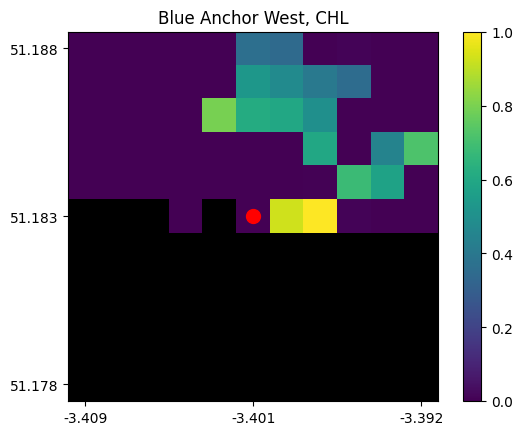

In [58]:
site_local_plot(ds, 'Blue Anchor West', 'CHL', 5)

In [10]:
sites_df['label']

0           Seaton Carew North
1          Seaton Carew Centre
2      Seaton Carew North Gare
3               Redcar Coatham
4      Redcar Lifeboat Station
                ...           
425            Teignmouth Town
426                    Shaldon
427                  Ness Cove
428              Hartland Quay
429               Westward Ho!
Name: label, Length: 430, dtype: object

### All 430 Sites, 31/10/2022

In [11]:
%%time
fig, axs = plt.subplots(nrows=108, ncols=4, figsize=(25, 500))
site_names = sites_df['label']

for i, ax in enumerate(axs.flatten()):
    if i < 430:
        site_local_plot(site_names[i], 'CHL', 5)
        plt.sca(ax)
        plt.xticks([])
        plt.yticks([])
        ax.set_facecolor('black')
    else:
        ax.axis('off')
        
plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show()

CPU times: user 25.9 s, sys: 984 ms, total: 26.9 s
Wall time: 27 s


### Comparing Across Two Dates

In [22]:
# !python -m pip install motuclient==1.8.4 --no-cache-dir

In [34]:
# # June 30th
# import os

# username = "slai"
# password = "Capstone2023"
# output_directory = "/Users/SallyLai/Desktop/LSE/Masters/Capstone/capstone-project-sewage-pollution"
# output_filename = "20220630.nc"
# product_id = "OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209-TDS"
# dataset_id = "cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m"

# query = ('python -m motuclient --motu https://nrt.cmems-du.eu/motu-web/Motu --service-id ' + product_id + ' --product-id ' + dataset_id + 
#          ' --longitude-min -11 --longitude-max 2 --latitude-min 49 --latitude-max 60 ' +
#          '--date-min "2022-06-30 00:00:00" --date-max "2022-06-30 23:59:59" ' +
#          '--variable CHL --variable SPM --variable TUR ' +
#          '--out-dir ' + output_directory + ' --out-name ' + output_filename +
#          ' --user ' + username + ' --pwd ' + password)

# os.system(query)

2023-03-09 17:09:38.100 [ INFO] Asynchronous mode set
2023-03-09 17:09:38.101 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:09:39.407 [ INFO] Requesting file to download (this can take a while)...
2023-03-09 17:09:45.216 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:09:53.736 [ INFO] Product is not yet available (request in progress)
2023-03-09 17:10:03.730 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:10:10.458 [ INFO] The product is ready for download
2023-03-09 17:10:10.458 [ INFO] Downloading file (this can take a while)...
2023-03-09 17:10:10.718 [ INFO] File type: application/x-netcdf
2023-03-09 17:10:10.720 [ INFO] File size: 1.1 GB (1061269504 B)
2023-03-09 17:10:10.720 [ INFO] Downloading file /Users/SallyLai/Desktop/LSE/Masters/Capstone/capstone-project-sewage-pollution/20220630.nc
2023-03-09 17:10:12.761 [ INFO] -   1.1 GB (

0

In [61]:
# Load New Data
# Time coverage start and stop shows 20221031, but we suspect this may be a bug (and the data is indeed June)
june_thirty = nc.Dataset("20220630.nc")
for dim in ds.dimensions.values():
    print(dim)
june_thirty

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 11554
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 7377


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TileSize: 945:1192
    id: 20221031_P1D_CMEMS_HROC_L4_tur-spm-chl_NWS__100m-v01.2.nc
    title: CMEMS HR-OC North West Shelf Region transparency (spm, tur) and geophysical (chl) daily interpolated observations mosaic
    region: NWS
    tile: 
    cmems_product_id: OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209
    cmems_dataset: cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m
    institution: Brockmann Consult GmbH, RBINS, VITO for CMEMS, Mercator Ocean
    source: Sentinel-2 MSI L1C
    history: Calvalus 2.21 mosaic generation; Acolite 20210203; C2RCC 8.0cv; Idepix 8.0cv; HROC L2W 20201223; Calvalus 2.21 aggregation
    references: https://marine.copernicus.eu/
    license: CMEMS data license
    tracking_id: de0f7357-f9c0-4d2b-b4d7-40d55c0ae086
    product_version: v01.2
    summary: The HR-OC product has been processed from Sentinel-2 MSI L1C by pixel identification, atmospheric corr

In [96]:
# Function to Calculate Comparison 
def comparison_plot(ds1, ds2, site_name, variable, dimension = 5):
    '''
    Assumes that lat_index and lon_index snaps the lat and lon point to the same grid across datasets
    '''
    lat = float(sites_df[sites_df['label'] == site_name]['lat'])
    lon = float(sites_df[sites_df['label'] == site_name]['long'])
    
    # First dataset
    lats = ds1['lat'][:].data
    lons = ds1['lon'][:].data
    
    lat_index = np.argmin(np.abs(lats - lat))
    lon_index = np.argmin(np.abs(lons - lon))
    
    i = dimension
    arr1 = ds1[f'{variable}'][0,lat_index-i:lat_index+i+1,lon_index-i:lon_index+i+1].data
    
    # Second dataset
    lats = ds2['lat'][:].data
    lons = ds2['lon'][:].data
    
    lat_index = np.argmin(np.abs(lats - lat))
    lon_index = np.argmin(np.abs(lons - lon))
    
    i = dimension
    arr2 = ds2[f'{variable}'][0,lat_index-i:lat_index+i+1,lon_index-i:lon_index+i+1].data
    
    # Mask for when the arrays have the same values
    mask_same = np.logical_xor(np.isnan(arr1), np.isnan(arr2))
    mask_same = np.logical_not(mask_same)
    
    # Mask for when the arrays have the same values
    mask_same = np.logical_xor(np.isnan(arr1), np.isnan(arr2))
    mask_same = np.logical_not(mask_same)

    # Plot
    plt.imshow(mask_same, cmap='Set1')
    
    # Colorbar
    plt.colorbar()

    # Changing Ticks to match latitude and longitude
    new_xticks = [round(lons[j], 3) for j in np.arange(lon_index-i, lon_index+i+1)][::5]
    plt.xticks(range(len(new_xticks)*5)[::5], new_xticks)
    new_yticks = [round(lats[j], 3) for j in np.arange(lat_index-i, lat_index+i+1)][::5]
    plt.yticks(range(len(new_yticks)*5)[::5], new_yticks)

    # Add Title
    plt.title(f'{site_name}, {variable}')

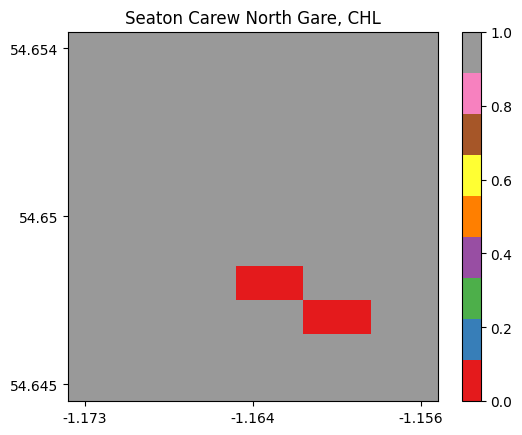

In [97]:
site = sites_df['label'][2]
comparison_plot(ds, june_thirty, site, 'CHL', 5)

In [98]:
%%time
fig, axs = plt.subplots(nrows=108, ncols=4, figsize=(25, 500))
site_names = sites_df['label']

for i, ax in enumerate(axs.flatten()):
    if i < 430:
        comparison_plot(ds, june, site_names[i], 'CHL', 5)
        plt.sca(ax)
        plt.xticks([])
        plt.yticks([])
        ax.set_facecolor('black')
    else:
        ax.axis('off')
        
plt.subplots_adjust(wspace=0.2, hspace=0.6)
plt.show()

CPU times: user 24.8 s, sys: 1.32 s, total: 26.1 s
Wall time: 26.7 s


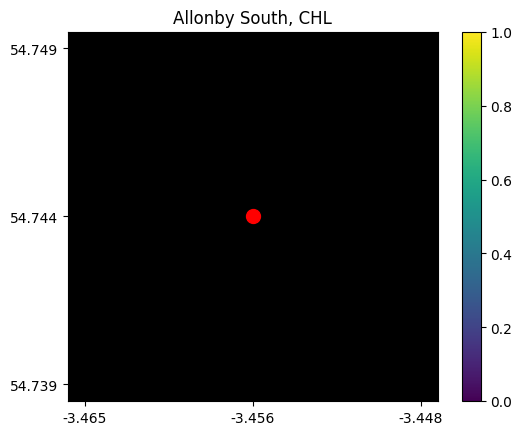

In [99]:
# Plotting just for new dataset
site_local_plot(june, 'Allonby South', 'CHL', 5)

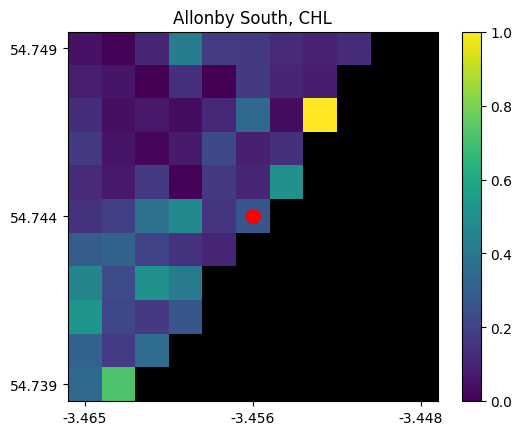

In [100]:
site_local_plot(ds, 'Allonby South', 'CHL', 5)

In [63]:
# File Size Download Limit of 2048Mb / 2.048 Gb
# Max Download 2 days at a time
# import os

# username = "slai"
# password = "Capstone2023"
# output_directory = "/Users/SallyLai/Desktop/LSE/Masters/Capstone/capstone-project-sewage-pollution/copernicus_code"
# output_filename = "20220301_02.nc"
# product_id = "OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209-TDS"
# dataset_id = "cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m"

# query = ('python -m motuclient --motu https://nrt.cmems-du.eu/motu-web/Motu --service-id ' + product_id + ' --product-id ' + dataset_id + 
#          ' --longitude-min -11 --longitude-max 2 --latitude-min 49 --latitude-max 60 ' +
#          '--date-min "2022-03-01 00:00:00" --date-max "2022-03-02 23:59:59" ' +
#          '--variable CHL --variable SPM --variable TUR ' +
#          '--out-dir ' + output_directory + ' --out-name ' + output_filename +
#          ' --user ' + username + ' --pwd ' + password)

# os.system(query)

2023-03-09 17:42:16.300 [ INFO] Asynchronous mode set
2023-03-09 17:42:16.300 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:42:17.429 [ INFO] Requesting file to download (this can take a while)...
2023-03-09 17:42:23.212 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:42:30.459 [ INFO] Product is not yet available (request in progress)
2023-03-09 17:42:40.465 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:42:47.509 [ INFO] Product is not yet available (request in progress)
2023-03-09 17:42:57.513 [ INFO] Authenticating user slai for service https://nrt.cmems-du.eu/motu-web/Motu
2023-03-09 17:43:04.768 [ INFO] The product is ready for download
2023-03-09 17:43:04.769 [ INFO] Downloading file (this can take a while)...
2023-03-09 17:43:05.153 [ INFO] File type: application/x-netcdf
2023-03-09 17:43:05.154 [ INFO] File size: 2.1 GB (21223796

0

In [ ]:
# Collate over 7 days

username = "slai"
password = "Capstone2023"
product_id = "OCEANCOLOUR_NWS_BGC_HR_L4_NRT_009_209-TDS"
dataset_id = "cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m"

# Change the following
output_directory = "/Users/SallyLai/Desktop/LSE/Masters/Capstone/capstone-project-sewage-pollution/copernicus_code"
start = '01'
end = '02'
output_filename = f"202203{start}_{end}.nc"

    
query = ('python -m motuclient --motu https://nrt.cmems-du.eu/motu-web/Motu --service-id ' + product_id + ' --product-id ' + dataset_id + 
         ' --longitude-min -11 --longitude-max 2 --latitude-min 49 --latitude-max 60 ' +
         '--date-min "2022-03-01 00:00:00" --date-max "2022-03-02 23:59:59" ' +
         '--variable CHL --variable SPM --variable TUR ' +
         '--out-dir ' + output_directory + ' --out-name ' + output_filename +
         ' --user ' + username + ' --pwd ' + password)

os.system(query)


# Big Plot (cannot make...) 

In [ ]:
# conda install -c conda-forge cartopy

In [101]:
# arr = ds['CHL'][0, :, :].data

# # Create a mask array
# mask = np.isnan(arr)

# fig = plt.figure(figsize=(100, 100))

# # Plot the numpy array as an image
# plt.imshow(arr, cmap='jet')

# # Plot the mask array on top of the numpy array
# plt.imshow(mask, cmap='gray', alpha=0.3)

# # Add a colorbar
# cbar = plt.colorbar()
# cbar.set_label('Value')

# # Change ticks
# plt.xticks(lons)
# plt.yticks(lats)
# # plt.xlim(lons[0], lons[-1])
# # plt.ylim(lats[0], lats[-1])

# # Show the plot
# plt.show()

In [ ]:
# !conda install cartopy --yes

In [ ]:
# !pip uninstall lxml
# !ARCHFLAGS="-arch arm64" pip install lxml --compile --no-cache-dir

In [ ]:
# zsd = ds['CHL'][0,:,:].data
# zsd

In [ ]:
# arr = zsd

# # Create a mask array
# mask = np.isnan(arr)

# # Create a map with the appropriate projection
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Plot the numpy array as an image
# im = ax.imshow(arr, cmap='jet', transform=ccrs.PlateCarree())

# # Plot the mask array on top of the numpy array
# ax.imshow(mask, cmap='gray', alpha=0.3, transform=ccrs.PlateCarree())

# # Add a colorbar
# cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.04)
# cbar.set_label('Value')

# # Add map features
# ax.coastlines()
# ax.gridlines()

# # Show the plot
# plt.show()

In [ ]:
# !pip3 install cartopy

In [ ]:
# import matplotlib
# # import cartopy

# print('Matplotlib version:', matplotlib.__version__)
# print('Cartopy version:', cartopy.__version__)

In [ ]:
# from platform import python_version

# print(python_version())

In [ ]:
# !pip install --upgrade matplotlib

In [ ]:
# zsd = ds['CHL'][0,:,:].data

# plt.imshow(zsd, cmap='hot', interpolation='nearest');

In [ ]:
# zsd.shape

In [ ]:
# from matplotlib import cm

# zsd = ds['CHL'][0,:,:].data


# # (n_snapshots, w, h) = ds['CHL'][:,:,:].data.shape
# # date = datetime.date(1900, 1, 1) + datetime.timedelta(days=int(ds['time'][0].data))

# #img = Image.fromarray(np.where(-999, 0, zsd))
# # arr = (255 - np.where(zsd == -999, 0, zsd) / zsd.max() * 255).astype(np.uint8)
# # arr = (255 - np.where(zsd == -999, 0, zsd) / zsd.max() * 255).astype(np.uint8)
# arr = (255 - np.where(zsd == -999, 0, zsd) / zsd.max() * 255).astype(np.uint8)

# # img = Image.fromarray(cm.viridis(arr),mode='L')

# # plt.imsave('test.png', arr, cmap='viridis')
# img = Image.fromarray(arr,mode='L').convert('RGB')
# # img = img.resize((700, 700))
# img